# Model Training

## Import Data and Required Packages

In [16]:
# Basic Imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

# Modeling
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

In [10]:
df = pd.read_csv('data/stud.csv')
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


## 2. Preparing X and Y variables

Since math score was consisted of the lowest performance from all groups, I will try to predict the math scores. 'math_score' will become my target/output/dependent variables, and the rest will become the independent features. 

In [7]:
X = df.drop(columns=['math_score'], axis=1)
y = df['math_score']

In [8]:
print("Categories in 'gender' feature: ", end=" ")
print(df['gender'].unique())
print("\n")

print("Categories in 'race_ethnicity' feature: ", end=" ")
print(df['race_ethnicity'].unique())
print("\n")

print("Categories in 'parental_level_of_education' feature: ", end=" ")
print(df['parental_level_of_education'].unique())
print("\n")

print("Categories in 'lunch' feature: ", end=" ")
print(df['lunch'].unique())
print("\n")

print("Categories in 'test_preparation_course' feature: ", end=" ")
print(df['test_preparation_course'].unique())

Categories in 'gender' feature:  ['female' 'male']


Categories in 'race_ethnicity' feature:  ['group B' 'group C' 'group A' 'group D' 'group E']


Categories in 'parental_level_of_education' feature:  ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']


Categories in 'lunch' feature:  ['standard' 'free/reduced']


Categories in 'test_preparation_course' feature:  ['none' 'completed']


### Creating Column Transformer with 3 types of transformer

Out of our 7 independent variables, 5 of them are categorical features instead of numerical.
- For gender we have 2 categories
- For race/ethnicity we have 5 
- For parent's level of education we have 6
- For lunch we have 2
- For test prep we have 2

For these features we will perform some data preprocessing with a pipeline(to streamline) to convert them into numerical features using one hot encoding and standardize the numerical features.

In [11]:
num_features = X.select_dtypes(exclude='object').columns
cat_features = X.select_dtypes(include='object').columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

# Column transfomer will combine the encoder and the scaler in our pipeline and transforms the data in that order, pretty cool
preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
        ("StandardScaler", numeric_transformer, num_features),
    ]
)

# Applying the pipeline preprocessor to transform our data
X = preprocessor.fit_transform(X)

In [13]:
# Transformed X
X

array([[ 1.        ,  0.        ,  0.        , ...,  1.        ,
         0.19399858,  0.39149181],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         1.42747598,  1.31326868],
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
         1.77010859,  1.64247471],
       ...,
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.12547206, -0.20107904],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.60515772,  0.58901542],
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
         1.15336989,  1.18158627]])

In [14]:
X.shape

(1000, 19)

In [ ]:
# Separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Data has been split for 80% training and 20% testing
X_train.shape, X_test.shape

((800, 19), (200, 19))

## Creating an evaluation function

In [23]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2 = r2_score(true, predicted)
    return mae, rmse, r2

In [26]:
# Models I'll be utilizing
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Extreme Gradient Boost": XGBRegressor(),
    "Categorical Boosting": CatBoostRegressor(verbose=False),
    "Adaptive Boosting": AdaBoostRegressor(),
}

model_list = []
r2_list = []
mae_list = []
rmse_list = []

for i in range(len(list(models))):
    model = list(models.values())[i]

    # Train Model
    model.fit(X_train, y_train)

    # Make Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    """
        Evaluate Train and Test dataset

        Training Data Evalaution helps us measure how well the model has leanred the patterns in the training set.
        If the model performs well on the training data but does poorly with the testing data then it can indicate
        overfitting and the model is not generalizing with the testing data.

        Testing Data Evaluation assesses how well does the model generalize to newer, unseen data. Since the test set
        was not used during the training of the model.
    """
    model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
    model_test_mae, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])

    print('Model performance for training set:')
    print('- Root Mean Square Error: {:.4f}'.format(model_train_rmse))
    print('- Mean Absolute Error: {:.4f}'.format(model_train_mae))
    print('- R2 Score: {:.4f}'.format(model_train_r2))

    print('------------------------------------')

    print('Model performance for testing set:')
    print('- Root Mean Square Error: {:.4f}'.format(model_test_rmse))
    print('- Mean Absolute Error: {:.4f}'.format(model_test_mae))
    print('- R2 Score: {:.4f}'.format(model_test_r2))
    r2_list.append(model_test_r2)
    rmse_list.append(model_test_rmse)
    mae_list.append(model_test_mae)

    print('='*35)
    print('\n')

Linear Regression
Model performance for training set:
- Root Mean Square Error: 5.3257
- Mean Absolute Error: 4.2698
- R2 Score: 0.8742
------------------------------------
Model performance for testing set:
- Root Mean Square Error: 5.4212
- Mean Absolute Error: 4.2345
- R2 Score: 0.8792


Lasso
Model performance for training set:
- Root Mean Square Error: 6.5938
- Mean Absolute Error: 5.2063
- R2 Score: 0.8071
------------------------------------
Model performance for testing set:
- Root Mean Square Error: 6.5197
- Mean Absolute Error: 5.1579
- R2 Score: 0.8253


Ridge
Model performance for training set:
- Root Mean Square Error: 5.3233
- Mean Absolute Error: 4.2650
- R2 Score: 0.8743
------------------------------------
Model performance for testing set:
- Root Mean Square Error: 5.3904
- Mean Absolute Error: 4.2111
- R2 Score: 0.8806


K-Neighbors
Model performance for training set:
- Root Mean Square Error: 5.7079
- Mean Absolute Error: 4.5168
- R2 Score: 0.8555
------------------

## Results

In [28]:
r2_rank = pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=['R2_Score'], ascending=False)
r2_rank

,Model Name,R2_Score
2,Ridge,0.880593
0,Linear Regression,0.879222
7,Categorical Boosting,0.851632
5,Random Forest,0.851031
8,Adaptive Boosting,0.846313
6,Extreme Gradient Boost,0.827797
1,Lasso,0.825320
3,K-Neighbors,0.783813
4,Decision Tree,0.739108


In [34]:
mae_rank = pd.DataFrame(list(zip(model_list, mae_list)), columns=['Model Name', 'MAE_Score']).sort_values(by=['MAE_Score'], ascending=True)
mae_rank

,Model Name,MAE_Score
2,Ridge,4.211101
0,Linear Regression,4.234531
7,Categorical Boosting,4.612532
5,Random Forest,4.682300
8,Adaptive Boosting,4.785224
6,Extreme Gradient Boost,5.057731
1,Lasso,5.157882
3,K-Neighbors,5.621000
4,Decision Tree,6.295000


In [33]:
rmse_rank = pd.DataFrame(list(zip(model_list, rmse_list)), columns=['Model Name', 'RMSE_Score']).sort_values(by=['RMSE_Score'], ascending=True)
rmse_rank

,Model Name,RMSE_Score
2,Ridge,5.390387
0,Linear Regression,5.421247
7,Categorical Boosting,6.008632
5,Random Forest,6.020777
8,Adaptive Boosting,6.115391
6,Extreme Gradient Boost,6.473307
1,Lasso,6.519695
3,K-Neighbors,7.253041
4,Decision Tree,7.967747


### Results Summary

From all three metrics we can see that Ridge Regression performed the best with having the highest r2 scores explaining 88% of the variance and also have the lowest MAE and RMSE scores.

## Ridge Model

In [35]:
ridge = Ridge(fit_intercept=True)
ridge = ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
score = r2_score(y_test, y_pred)*100
print('Accuracy of Ridge Model is %.2f' %score)

Accuracy of Ridge Model is 88.06


## Plotting y_pred and y_test

Text(0, 0.5, 'Predicted')

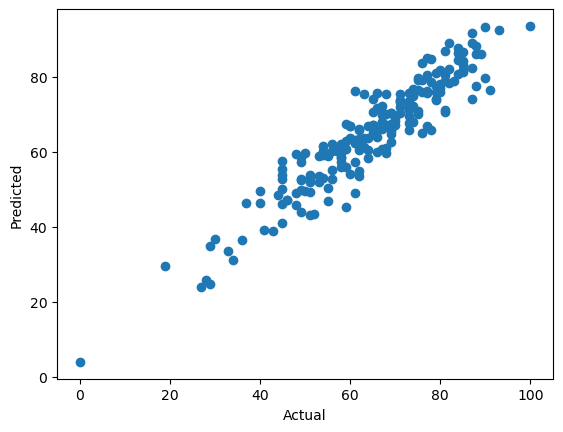

In [36]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')

<Axes: xlabel='math_score'>

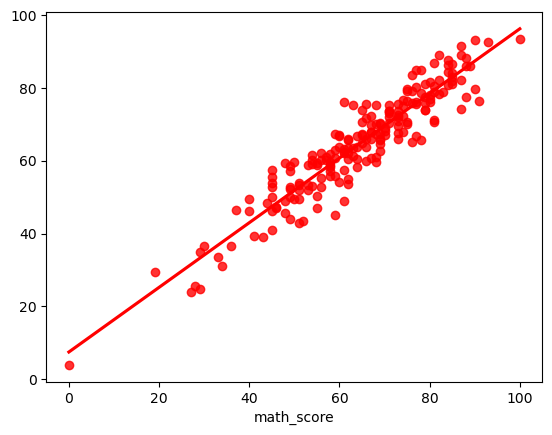

In [37]:
sns.regplot(x=y_test, y=y_pred, ci=None, color='red')

## Difference between Actal and Predicted Values

In [38]:
pred_df = pd.DataFrame({'Actual Value': y_test, 'Predicted Value': y_pred, 'Difference': y_test - y_pred})
pred_df

,Actual Value,Predicted Value,Difference
521,91,76.398705,14.601295
737,53,58.842469,-5.842469
740,80,76.992129,3.007871
660,74,76.805898,-2.805898
411,84,87.615387,-3.615387
...,...,...,...
408,52,43.492293,8.507707
332,62,62.170763,-0.170763
208,74,67.910325,6.089675
613,65,67.061504,-2.061504


## Modular Programming

So far we have worked on two jupyter notebooks from EDA to model training, but industry usually doesn't do this when making a production ML product. They utilize modular programming where instead of having everything in a singular Jupyter Notebook, you modularize your code into different specific directories and files for each stage like data ingestion, preprocessing, training, evaluation, deployment, etc. And there are several benefits for this:

1. **Maintainability & Readability**
- Easier to locate, debug, modify, and extend since each part of the pipeline is separate
- Clearer structure instead of one long script that's hard to navigate

2. **Resuability**
- Components (e.g., data processing functions, model training scripts) can be reused across projects without having to rewrite code
- This is where the utils.py file can come in handy

3. **Scalability**
- Large ML projects can involve multiple teams(data engineers, ML engineers, software developers). A structured modular setup allows teams to work on different parts independently.

4. **Version Control & CI/CD**
- Industry practices Git and CI/CD pipelines to tack changes, test individual components, and deploy models efficiently

5. **Production Readiness**
- Jupyter notebooks are great for prototyping, but for deployment, ML models need to run as scripts, services, or APIs (e.g., Flask, FastAPI, or in cloud enivronments like AWS, GCP)